In [ ]:
from ase.build import bulk

import numpy as np

from ase import Atoms
from ase.atom import Atom

import pyiron_workflow as pwf
from pyiron_workflow import Workflow
from pyiron_workflow_atomistics.bulk import eos_volume_scan, get_equil_lat_param, get_bulk_structure
from pyiron_workflow_atomistics.calculator import calculate_structure_node
from pyiron_workflow_atomistics.gb.gb_code.constructor import construct_GB_from_GBCode
from pyiron_workflow_atomistics.calculator import ase_calculate_structure_node_interface

# from tensorpotential.calculator import TPCalculator
from pyiron_workflow import Workflow
from pyiron_workflow_lammps.calculator import lammps_calculator_node
from pyiron_workflow_atomistics.gb.dataclass_storage import PlotCleaveInput, CalcStructureInput, CleaveGBStructureInput
from pyiron_workflow_lammps.lammps import lammps_job, LammpsInput
from pyiron_workflow_lammps.calculator import lammps_calculator_node
import os

from pyiron_workflow_atomistics.bulk import get_cubic_equil_lat_param
%load_ext autoreload
%autoreload 2

In [74]:
@pwf.api.as_function_node("toten_gb_novac")
def _get_toten_gb_novac(gb_length_optimiser):
    return min([row.results["energy"] for _, row in gb_length_optimiser.outputs.to_value_dict()["concat_results"].iterrows()])

@pwf.api.as_function_node("surface_energy")
def _get_surface_energy(total_energy_gb_vac, total_energy_gb_novac, area):
    surface_energy = (total_energy_gb_vac - total_energy_gb_novac) / area * 16.021766208 / 2
    return surface_energy

@pwf.api.as_function_node("area")
def _get_area(gb_with_vacuum_rel):
    area = gb_with_vacuum_rel.outputs.atoms.value.cell.volume / gb_with_vacuum_rel.outputs.atoms.value.cell[-1][-1]
    return area

@pwf.api.as_macro_node("initial_pure_grain_boundary_structure",
                       "final_pure_grain_boundary_structure",
                       "final_pure_grain_boundary_structure_energy",
                       "grain_boundary_length_optimisation_df",
                       "grain_boundary_energy",
                       "grain_boundary_excess_volume",
                       "surface_energy",
                       "pure_grain_boundary_structure_vacuum",
                       "pure_grain_boundary_structure_vacuum_energy",
                       "work_of_separation_rigid",
                       "work_of_separation_rigid_df",
                       "work_of_separation_relaxed",
                       "work_of_separation_relaxed_df",
                       )
def pure_gb_optimiser(wf,
                      gb_structure,
                      equil_bulk_volume,
                      equil_bulk_energy,
                      extensions_stage1,
                      extensions_stage2,
                      calc_structure_fn,
                      calc_structure_fn_kwargs,
                      length_interpolate_min_n_points=5,
                      gb_normal_axis="c",
                      vacuum_length=20,
                      min_inplane_cell_length=6,
                      ):
    from pyiron_workflow_atomistics.gb.optimiser import full_gb_length_optimization
    wf.gb_length_optimiser = full_gb_length_optimization(
        gb_structure=gb_structure,
        calc_structure_fn=calc_structure_fn,
        calc_structure_fn_kwargs=calc_structure_fn_kwargs,
        equil_bulk_volume=equil_bulk_volume,
        equil_bulk_energy=equil_bulk_energy,
        extensions_stage1=extensions_stage1,
        extensions_stage2=extensions_stage2,
        interpolate_min_n_points=length_interpolate_min_n_points,
        gb_normal_axis=gb_normal_axis
    )
    from pyiron_workflow_atomistics.structure_manipulator.tools import add_vacuum
    wf.gb_with_vacuum = add_vacuum(wf.gb_length_optimiser.outputs.gb_structure_final,
                                vacuum_length = vacuum_length,
                                axis = gb_normal_axis)
    wf.gb_with_vacuum_rel =  calculate_structure_node(
                                            structure = wf.gb_with_vacuum,
                                            calc_structure_fn=calc_structure_fn,
                                            calc_structure_fn_kwargs=calc_structure_fn_kwargs,
                                            )
    from pyiron_workflow_atomistics.structure_manipulator.tools import create_supercell_with_min_dimensions

    wf.gb_seg_supercell = create_supercell_with_min_dimensions(wf.gb_with_vacuum_rel.outputs.atoms, 
                                                            min_dimensions=[min_inplane_cell_length, min_inplane_cell_length, None])
    wf.gb_seg_supercell_rel =  calculate_structure_node(
                                            structure = wf.gb_seg_supercell,
                                            calc_structure_fn=calc_structure_fn,
                                            calc_structure_fn_kwargs=calc_structure_fn_kwargs,
                                            )
    wf.area = _get_area(wf.gb_with_vacuum_rel.outputs.atoms)
    wf.toten_gb_novac = _get_toten_gb_novac(wf.gb_length_optimiser)
    wf.surface_energy = _get_surface_energy(wf.gb_with_vacuum_rel.outputs.results.energy, wf.toten_gb_novac)
    return wf.gb_structure.outputs.final_structure,\
            wf.gb_length_optimiser.outputs.gb_structure_final,\
            wf.toten_gb_novac,\
            wf.gb_length_optimiser.outputs.gb_structure_final,\
            wf.gb_length_optimiser.outputs.stage2_opt_GBEnergy,\
            wf.gb_length_optimiser.outputs.stage2_opt_excvol,\
            wf.surface_energy,\
            wf.gb_with_vacuum_rel.outputs.atoms,\
            wf.gb_with_vacuum_rel.outputs["results"]["energy"],\
            wf.calc_cleavage_relax.outputs["cleavage_calcs_df"].cleavage_energy.min(),\
            wf.calc_cleavage_relax.outputs.cleavage_calcs_df,\
            wf.calc_cleavage_rigid.outputs["cleavage_calcs_df"].cleavage_energy.min(),\
            wf.calc_cleavage_rigid.outputs.cleavage_calcs_df
            
working_directory = "pure_gb_optimiser"
wf1 = Workflow(working_directory)
wf1.gb_structure = construct_GB_from_GBCode(
    axis=(1, 1, 1),
    basis="bcc",
    lattice_param=wf.optimise_cubic_lattice_parameter.outputs.a0.value,
    m=3,
    n=1,
    GB1=(-1, -1, 2),
    element="Fe",
    req_length_grain=15,
    grain_length_axis=0,
    arrange_ab_by_length=True,
    perform_equiv_check=False,
    merge_dist_tolerance=1.3,
    merge_mode="average",
    equil_volume=wf.optimise_cubic_lattice_parameter.outputs.equil_volume_per_atom.value
)
wf1.run()

0


/root/miniconda3/envs/pyiron_workflow/lib/python3.12/site-packages/pymatgen/core/structure.py:3106: BadPoscarWarning: Elements in POSCAR cannot be determined. Defaulting to false names ['H', 'H', 'H', 'H', 'H', 'H', 'He', 'He', 'He', 'He', 'He', 'He'].
  struct = Poscar.from_str(input_string, default_names=None, read_velocities=False, **kwargs).structure
/root/miniconda3/envs/pyiron_workflow/lib/python3.12/site-packages/pymatgen/core/structure.py:3106: BadPoscarWarning: Elements in POSCAR cannot be determined. Defaulting to false names ['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'He', 'He', 'He', 'He', 'He', 'He', 'He', 'He', 'He', 'He', 'He', 'He', 'He', 'He', 'He', 'He', 'He', 'He'].
  struct = Poscar.from_str(input_string, default_names=None, read_velocities=False, **kwargs).structure


{'gb_structure__original_GBcode_structure': MSONAtoms(symbols='Fe36', pbc=True, cell=[41.5646304, 2.44921933, 3.99955843]),
 'gb_structure__final_structure': MSONAtoms(symbols='Fe36', pbc=True, cell=[[2.44921933, 0.0, 1.4997143064471626e-16], [6.431780499988128e-16, 3.99955843, 2.449023214651157e-16], [0.0, 0.0, 41.564630436739535]])}

In [73]:
wf.optimise_cubic_lattice_parameter.outputs.to_value_dict()

{'a0': 2.8281148843860726,
 'B': 166.09857290100913,
 'equil_energy_per_atom': -8.237265227013868,
 'equil_volume_per_atom': 11.309962028280323,
 'volumes': [22.24968758437601,
  22.523246272461307,
  22.79903808034361,
  23.077072085745662,
  23.35735736639019,
  23.63990300000001,
  23.92471806429778,
  24.211811637006328,
  24.50119279584838,
  24.792870618546676,
  25.086854182823995],
 'structures': [Atoms(symbols='Fe2', pbc=True, cell=[[2.8126, 1.7222207936409228e-16, 1.7222207936409228e-16], [0.0, 2.8126, 1.7222207936409226e-16], [0.0, 0.0, 2.8126]]),
  Atoms(symbols='Fe2', pbc=True, cell=[[2.82408, 1.7292502662680285e-16, 1.7292502662680285e-16], [0.0, 2.82408, 1.729250266268029e-16], [0.0, 0.0, 2.82408]]),
  Atoms(symbols='Fe2', pbc=True, cell=[[2.8355599999999996, 1.7362797388951345e-16, 1.7362797388951345e-16], [0.0, 2.8355599999999996, 1.7362797388951342e-16], [0.0, 0.0, 2.8355599999999996]]),
  Atoms(symbols='Fe2', pbc=True, cell=[[2.84704, 1.7433092115222402e-16, 1.743309

In [ ]:

working_directory = "bulk_cubic_lattice_parameter_optimisation"

wf = Workflow(working_directory, delete_existing_savefiles=True)

wf.structure = get_bulk_structure(name="Fe",
                                  crystalstructure="bcc",
                                  cubic=True)

lmp_input = LammpsInput(
    read_data_file="lammps.data",
    pair_coeff=(
        "*", "*",
        "/root/github_dev/test_workflow_nodes/2025_04_29_FeGB_Segregation_Workflows/final_model",
        "Fe"
    ),
    dump_every=10,
    dump_filename="dump.out",
    thermo_every=10,
    min_style="cg",
    etol=0.00001,
    ftol=0.00001,
    maxiter=1_000_000,
    maxeval=1_000_000,
)
potential_elements = ["Fe"]
lammps_calculator_input = {
    "working_directory": working_directory,
    "lmp_input": lmp_input,
    "potential_elements": potential_elements,
    "input_filename": "in.lmp",
    "lammps_log_filepath": "minimize.log",
    "command": "/root/github_dev/lammps/build/lmp -in in.lmp -log minimize.log",
    "lammps_log_convergence_printout": "Total wall time:",
}
from pyiron_workflow_atomistics.bulk import optimise_cubic_lattice_parameter
wf.optimise_cubic_lattice_parameter = optimise_cubic_lattice_parameter(structure=wf.structure,
                                                                       rattle=0.01,
                                                                       crystalstructure="bcc",
                                                                       name="Fe",
                                                                       calc_structure_fn=lammps_calculator_node,
                                                                       calc_structure_fn_kwargs=lammps_calculator_input,
                                                                       strain_range=(-0.02, 0.02),
                                                                       num_points=11)




wf.run()

2025-07-16 02:02:44,242 - pyiron_log - WARNING - Could not find the source code to validate get_cubic_equil_lat_param output labels against the number of returned values -- proceeding without validation


{'optimise_cubic_lattice_parameter__a0': 2.8281148843860726,
 'optimise_cubic_lattice_parameter__B': 166.09857290100913,
 'optimise_cubic_lattice_parameter__equil_energy_per_atom': -8.237265227013868,
 'optimise_cubic_lattice_parameter__equil_volume_per_atom': 11.309962028280323,
 'optimise_cubic_lattice_parameter__volumes': [22.24968758437601,
  22.523246272461307,
  22.79903808034361,
  23.077072085745662,
  23.35735736639019,
  23.63990300000001,
  23.92471806429778,
  24.211811637006328,
  24.50119279584838,
  24.792870618546676,
  25.086854182823995],
 'optimise_cubic_lattice_parameter__structures': [Atoms(symbols='Fe2', pbc=True, cell=[[2.8126, 1.7222207936409228e-16, 1.7222207936409228e-16], [0.0, 2.8126, 1.7222207936409226e-16], [0.0, 0.0, 2.8126]]),
  Atoms(symbols='Fe2', pbc=True, cell=[[2.82408, 1.7292502662680285e-16, 1.7292502662680285e-16], [0.0, 2.82408, 1.729250266268029e-16], [0.0, 0.0, 2.82408]]),
  Atoms(symbols='Fe2', pbc=True, cell=[[2.8355599999999996, 1.736279738

2025-07-15 14:47:31,221 - pyiron_log - WARNING - Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/strain_000' already exists. Existing files may be overwritten.
2025-07-15 14:47:38,740 - pyiron_log - WARNING - Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/strain_001' already exists. Existing files may be overwritten.
2025-07-15 14:47:45,439 - pyiron_log - WARNING - Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/strain_002' already exists. Existing files may be overwritten.
2025-07-15 14:47:52,434 - pyiron_log - WARNING - Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/strain_003' already exists. Existing files may be overwritten.
2025-07-15 14:47:59,537 - pyiron_log - WARNING - Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/strain_004' already exists. Existing files may be overwritten.
2025-07-15 14:48:05,759 - pyiron_log - WARNING - Directory '/root/gith

0


2025-07-15 14:48:54,627 - pyiron_log - WARNING - Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/ext_0.300' already exists. Existing files may be overwritten.
2025-07-15 14:49:01,427 - pyiron_log - WARNING - Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/ext_-0.200' already exists. Existing files may be overwritten.
2025-07-15 14:49:08,971 - pyiron_log - WARNING - Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/ext_0.050' already exists. Existing files may be overwritten.
2025-07-15 14:49:15,283 - pyiron_log - WARNING - Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/ext_0.025' already exists. Existing files may be overwritten.
2025-07-15 14:49:22,034 - pyiron_log - WARNING - Directory '/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/ext_0.000' already exists. Existing files may be overwritten.
2025-07-15 14:49:28,758 - pyiron_log - WARNING - Directory '/root/github_d

injected_GetItem_m1696928711438299158 (GetItem):
Inputs ['obj', 'item']
OutputsWithInjection ['getitem']
InputSignals ['run', 'accumulate_and_run']
OutputSignals ['ran', 'failed']


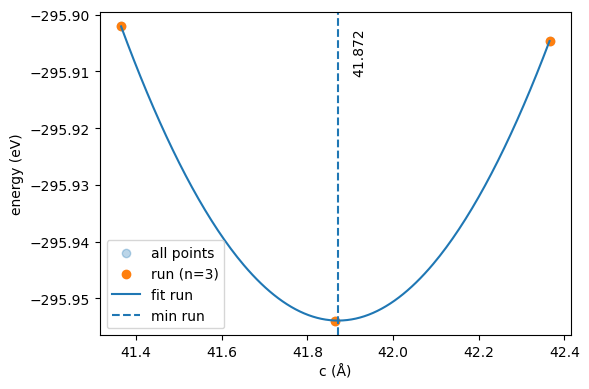

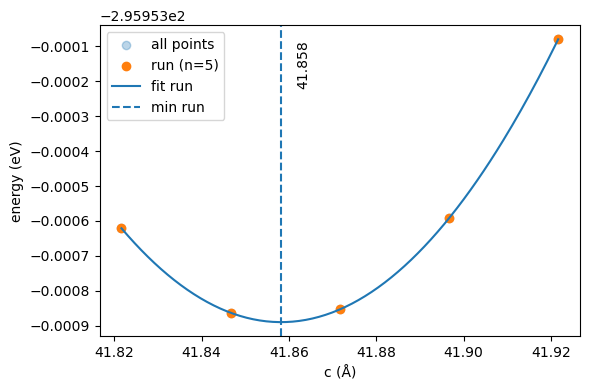

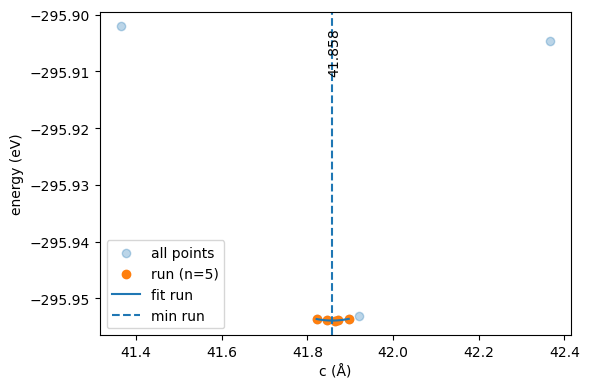

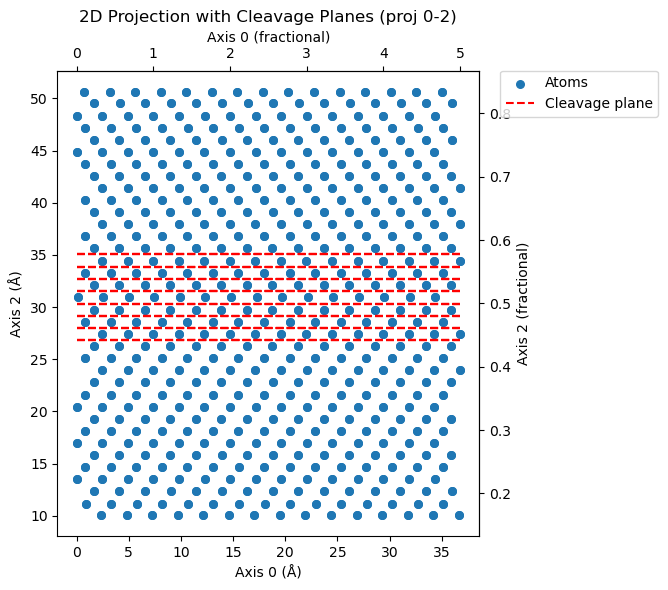

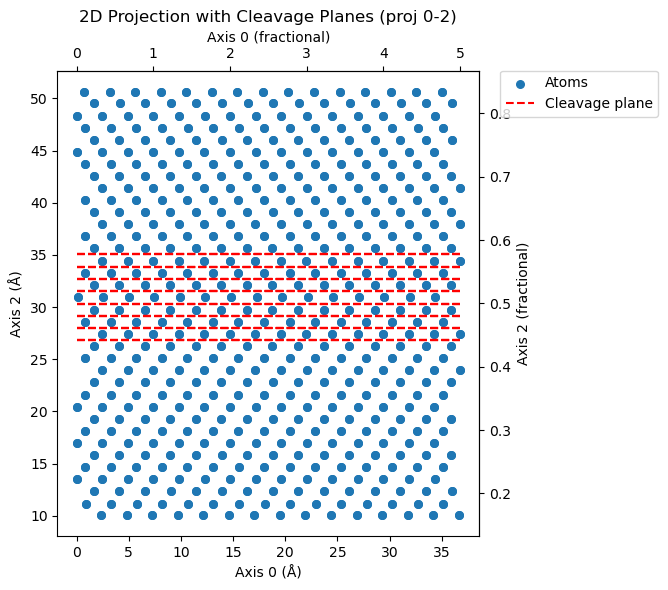

In [ ]:
# 1. Prepare calculator and workflow
import shutil

working_directory = "gb_optimiser_whole_lammps"
try:
    shutil.rmtree(working_directory, ignore_errors=True)
except:
    pass
wf   = Workflow(working_directory, delete_existing_savefiles=True)

# 2. Build your base Fe structure
bulk_Fe = bulk("Fe", cubic=True, a=2.83)
bulk_Fe.rattle()
working_directory = "/root/github_dev/test_workflow_nodes/gb_optimiser_whole_lammps/"
lmp_input = LammpsInput(
    read_data_file="lammps.data",
    pair_coeff=(
        "*", "*",
        "/root/github_dev/test_workflow_nodes/2025_04_29_FeGB_Segregation_Workflows/final_model",
        "Fe"
    ),
    dump_every=10,
    dump_filename="dump.out",
    thermo_every=10,
    min_style="cg",
    etol=0.00001,
    ftol=0.00001,
    maxiter=1_000_000,
    maxeval=1_000_000,
)
potential_elements = ["Fe"]
lammps_calculator_input = {
    "working_directory": working_directory,
    "lmp_input": lmp_input,
    "potential_elements": potential_elements,
    "input_filename": "in.lmp",
    "lammps_log_filepath": "minimize.log",
    "command": "/root/github_dev/lammps/build/lmp -in in.lmp -log minimize.log",
    "lammps_log_convergence_printout": "Total wall time:",
}

# 3. Attach the macro node to the workflow, capturing all outputs
wf.eos = eos_volume_scan(
    base_structure = bulk_Fe,
    calc_structure_fn = lammps_calculator_node,
    calc_structure_fn_kwargs = lammps_calculator_input,
    axes           = ["a", "b", "c"],
    strain_range   = (-0.02, 0.02),
    num_points     = 11,
)
wf.a0 = get_equil_lat_param(wf.eos.outputs.v0)
wf.eq_bulk_struct = get_bulk_structure(name = "Fe",
                           cubic = True,
                           a = wf.a0)
    
wf.equil_energy = get_per_atom_quantity(wf.eos.outputs.e0, wf.eq_bulk_struct.outputs.equil_struct)
wf.equil_volume = get_per_atom_quantity(wf.eos.outputs.v0, wf.eq_bulk_struct.outputs.equil_struct)

wf.gb_structure = construct_GB_from_GBCode(
    axis=(1, 1, 1),
    basis="bcc",
    lattice_param=wf.a0,
    m=3,
    n=1,
    GB1=(-1, -1, 2),
    element="Fe",
    req_length_grain=15,
    grain_length_axis=0,
    arrange_ab_by_length=True,
    perform_equiv_check=False,
    merge_dist_tolerance=1.3,
    merge_mode="average",
    equil_volume=wf.equil_volume
)
from pyiron_workflow_atomistics.gb.optimiser import full_gb_length_optimization
wf.gb_length_optimiser = full_gb_length_optimization(
    gb_structure=wf.gb_structure.outputs.final_structure,
    calc_structure_fn=lammps_calculator_node,
    calc_structure_fn_kwargs=lammps_calculator_input,
    equil_bulk_volume=wf.equil_volume,
    equil_bulk_energy=wf.equil_energy,
    extensions_stage1=np.linspace(-0.2, 0.8, 3),
    extensions_stage2=np.linspace(-0.05, 0.05, 5),
    interpolate_min_n_points=5,
    gb_normal_axis="c"
)
from pyiron_workflow_atomistics.gb.optimiser import gb_length_optimiser
from pyiron_workflow_atomistics.structure_manipulator.tools import add_vacuum
wf.gb_with_vacuum = add_vacuum(wf.gb_length_optimiser.outputs.gb_structure_final,
                               vacuum_length = 20,
                               axis = "c")
wf.gb_with_vacuum_rel =  calculate_structure_node(
                                        structure = wf.gb_with_vacuum,
                                        calc_structure_fn=lammps_calculator_node,
                                        calc_structure_fn_kwargs=lammps_calculator_input,
                                        )
from pyiron_workflow_atomistics.structure_manipulator.tools import create_supercell_with_min_dimensions

wf.gb_seg_supercell = create_supercell_with_min_dimensions(wf.gb_with_vacuum_rel.outputs.atoms, 
                                                           min_dimensions=[6, 6, None])
wf.gb_seg_supercell_rel =  calculate_structure_node(
                                        structure = wf.gb_seg_supercell,
                                        calc_structure_fn=lammps_calculator_node,
                                        calc_structure_fn_kwargs=lammps_calculator_input,
                                        )
from pyiron_workflow_atomistics.gb.cleavage import calc_cleavage_GB
wf.middle_atom = get_middle_atom(atoms = wf.gb_seg_supercell, axis = 2)
from pyiron_workflow_atomistics.utils import update_dataclass

wf.CleaveGBStructureInput = update_dataclass(CleaveGBStructureInput, "middle_atom", wf.middle_atom.outputs.atom)
@pwf.as_function_node("CleaveGBStructureInput")
def get_CleaveGBStructureInput(middle_atom,
                               axis_to_cleave="c",
                                tol=0.3,
                                cleave_region_halflength=5.0,
                                layer_tolerance=0.3,
                                separation=8.0,
                                use_fractional=False):
    return CleaveGBStructureInput(axis_to_cleave=axis_to_cleave,
                                  tol=tol,
                                  cleave_region_halflength=cleave_region_halflength,
                                  layer_tolerance=layer_tolerance,
                                  separation=separation,
                                  use_fractional=use_fractional,
                                  cleavage_target_coord=middle_atom.position[2])
wf.CleaveGBStructureInput = get_CleaveGBStructureInput(middle_atom=wf.middle_atom.outputs.atom)

lmp_input = LammpsInput(
    read_data_file="lammps.data",
    pair_coeff=(
        "*", "*",
        "/root/github_dev/test_workflow_nodes/2025_04_29_FeGB_Segregation_Workflows/final_model",
        "Fe"
    ),
    dump_every=10,
    dump_filename="dump.out",
    thermo_every=10,
    min_style="cg",
    etol=0.000001,
    ftol=0.000001,
    maxiter=0,
    maxeval=0,
)
potential_elements = ["Fe"]
lammps_calculator_input = {
    "working_directory": working_directory + "/cleavage_rigid",
    "lmp_input": lmp_input,
    "potential_elements": potential_elements,
    "input_filename": "in.lmp",
    "lammps_log_filepath": "minimize.log",
    "command": "/root/github_dev/lammps/build/lmp -in in.lmp -log minimize.log",
    "lammps_log_convergence_printout": "Total wall time:",
}

wf.calc_cleavage_rigid = calc_cleavage_GB(structure=wf.gb_seg_supercell_rel.outputs.atoms,
                                        energy = wf.gb_seg_supercell_rel.outputs.results["energy"],
                                        calc_structure_fn = lammps_calculator_node,
                                        calc_structure_fn_kwargs = lammps_calculator_input,
                                        parent_dir = working_directory + "/cleavage_rigid",
                                        input_cleave_gb_structure = wf.CleaveGBStructureInput.outputs.CleaveGBStructureInput,
                                        input_plot_cleave = PlotCleaveInput())
lmp_input = LammpsInput(
    read_data_file="lammps.data",
    pair_coeff=(
        "*", "*",
        "/root/github_dev/test_workflow_nodes/2025_04_29_FeGB_Segregation_Workflows/final_model",
        "Fe"
    ),
    dump_every=10,
    dump_filename="dump.out",
    thermo_every=10,
    min_style="cg",
    etol=0.00001,
    ftol=0.00001,
    maxiter=1000,
    maxeval=1000,
)
lammps_calculator_input = {
    "working_directory": working_directory + "/cleavage_relax",
    "lmp_input": lmp_input,
    "potential_elements": potential_elements,
    "input_filename": "in.lmp",
    "lammps_log_filepath": "minimize.log",
    "command": "/root/github_dev/lammps/build/lmp -in in.lmp -log minimize.log",
    "lammps_log_convergence_printout": "Total wall time:",
}
wf.calc_cleavage_relax = calc_cleavage_GB(structure=wf.gb_seg_supercell_rel.outputs.atoms,
                                        energy = wf.gb_seg_supercell_rel.outputs.results["energy"],
                                        calc_structure_fn = lammps_calculator_node,
                                        calc_structure_fn_kwargs = lammps_calculator_input,
                                        parent_dir = working_directory + "/cleavage_relax",
                                        input_cleave_gb_structure = wf.CleaveGBStructureInput.outputs.CleaveGBStructureInput,
                                        input_plot_cleave = PlotCleaveInput())
wf.run()
print(wf.middle_atom.outputs.atom.position[2])


In [17]:
wf.gb_length_optimiser.outputs.to_value_dict().keys()

dict_keys(['stage1_opt_struct', 'stage1_opt_excvol', 'stage1_opt_GBEnergy', 'stage2_opt_struct', 'stage2_opt_excvol', 'stage2_opt_GBEnergy', 'stage1_plot', 'stage2_plot', 'concat_results', 'combined_plot', 'gb_structure_final'])

In [ ]:
toten_gb_vac = wf.gb_with_vacuum_rel.outputs.to_value_dict()["results"]["energy"]
toten_gb_novac = min([row.results["energy"] for _, row in wf.gb_length_optimiser.outputs.to_value_dict()["concat_results"].iterrows()])
area = wf.gb_with_vacuum_rel.outputs.atoms.value.cell.volume / wf.gb_with_vacuum_rel.outputs.atoms.value.cell[-1][-1]

# eV/nm^2 to J/m^2
(toten_gb_vac - toten_gb_novac) / area * 16.021766208 / 2
## DFT is 2.42

2.33692399018226

In [ ]:




results_df

,equation_of_state_df,bulk_energy,initial_pure_grain_boundary_structure,final_pure_grain_boundary_structure,final_pure_grain_boundary_structure_energy,grain_boundary_length_optimisation_df,grain_boundary_energy,grain_boundary_excess_volume,surface_energy,pure_grain_boundary_structure_vacuum,pure_grain_boundary_structure_vacuum_energy,work_of_separation_relaxed,work_of_separation_relaxed_df,work_of_separation_rigid,work_of_separation_rigid_df
0,"{'v0': 22.620947979036114, 'e0': -16.474694469...",-8.237347234521938,"MSONAtoms(symbols='Fe36', pbc=True, cell=[[2.4...","MSONAtoms(symbols='Fe36', pbc=True, cell=[2.44...",-295.95388,"MSONAtoms(symbols='Fe36', pbc=True, cell=[2.44...",0.4829796230619328,0.146468682157158,2.336924,"Atoms(symbols='Fe36', pbc=True, cell=[[2.44925...",injected_GetItem_983167850756156422 (GetItem):...,<bound method Series.min of 0 5.088252\n1 ...,cleavage_coord ...,<bound method Series.min of 0 5.231640\n1 ...,cleavage_coord ...


In [8]:
wf.calc_cleavage_relax.outputs.cleavage_calcs_df.value

,cleavage_coord,initial_structure,final_structure,energy,cleavage_energy
0,26.818755,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.338172509490178, 1.917032021160...",-1739.915872,5.088252
1,27.978017,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.338304381098927, 1.967958870314...",-1739.890530,5.095160
2,29.132513,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.328945008600897, 1.827000703716...",-1741.430401,4.675410
3,30.318183,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.338594649930095, 2.012519863362...",-1741.449956,4.670079
4,31.540110,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.3386176043829336, 2.02797979970...",-1741.449574,4.670183
5,32.725690,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.3293097982229076, 1.63411526265...",-1741.428428,4.675947
6,33.879971,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.3382786500683737, 1.95068011792...",-1739.890124,5.095271
7,35.038987,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.3381657977276564, 1.90793794095...",-1739.915404,5.088380


In [9]:
wf.calc_cleavage_rigid.outputs.cleavage_calcs_df.value

,cleavage_coord,initial_structure,final_structure,energy,cleavage_energy
0,26.818755,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.340947640887537, 2.092547769895...",-1739.389849,5.231640
1,27.978017,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.340947640887537, 2.092547769895...",-1739.425671,5.221875
2,29.132513,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.340947640887537, 2.092547769895...",-1739.823518,5.113427
3,30.318183,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.340947640887537, 2.092547769895...",-1740.884046,4.824339
4,31.540110,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.340947640887537, 2.092547769895...",-1740.884313,4.824267
5,32.725690,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.340947640887537, 2.092547769895...",-1739.824663,5.113115
6,33.879971,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.340947640887537, 2.092547769895...",-1739.426637,5.221612
7,35.038987,"(Atom('Fe', [2.3409476408875367, 2.09254738162...","(Atom('Fe', [2.340947640887537, 2.092547769895...",-1739.389564,5.231718


/root/github_dev/pyiron_workflow_atomistics/notebooks
double peak detected
3 5


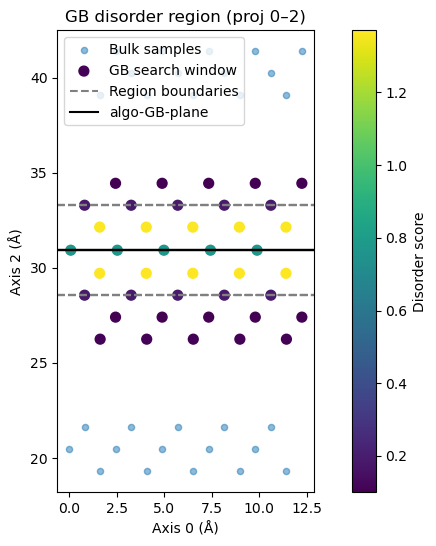

/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_21
/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_20
/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_19
/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_18
/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_17
/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_16
/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_15
/root/github_dev/pyiron_workflow_atomistics/notebooks
gb_seg_lammps/S3_RA110_S112_C_14


{'gb_plane_extractor_plot__fig': <Figure size 1000x600 with 2 Axes>,
 'gb_plane_extractor_plot__ax': <Axes: title={'center': 'GB disorder region (proj 0–2)'}, xlabel='Axis 0 (Å)', ylabel='Axis 2 (Å)'>,
 'gb_seg_calcs__output_df':                                            structure  \
 0  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 1  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 2  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 3  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 4  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 5  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 6  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 7  (Atom('Fe', [2.364341371230278, 2.093002703049...   
 
                             calc_structure_fn_kwargs  \
 0  {'lmp_input': units metal
 dimension 3
 boundary...   
 1  {'lmp_input': units metal
 dimension 3
 boundary...   
 2  {'lmp_input': units metal
 dimension 3
 boundary...   
 3  {'lmp_input': unit

In [ ]:

import shutil
import os
# os.chdir("/root/github_dev/test_workflow_nodes")
print(os.getcwd())
try:
    shutil.rmtree("gb_seg_lammps", ignore_errors=True)
    # Remove the entire tree and any files recursively
except:
    pass
wf2 = Workflow("gb_seg_lammps", delete_existing_savefiles=True)
wf2.gb_seg_supercell = create_supercell_with_min_dimensions(wf.gb_with_vacuum_rel.outputs.atoms.value, 
                                                           min_dimensions=[6, 6, None])

from pyiron_workflow_atomistics.featurisers import distanceMatrixSiteFeaturiser, voronoiSiteFeaturiser
from pyiron_workflow_atomistics.gb.analysis import plot_GB_plane, find_GB_plane
wf2.gb_plane_extractor = find_GB_plane(atoms = wf.gb_with_vacuum_rel.outputs.atoms.value,
                                        featuriser = voronoiSiteFeaturiser,
                                        axis = "c",
                                        approx_frac = 0.5,
                                        tolerance = 5.0,
                                        bulk_offset = 10.0,
                                        slab_thickness = 2.0,
                                        featuriser_kwargs = {},
                                        n_bulk = 10,
                                        threshold_frac = 0.3
                                      )
wf2.gb_plane_extractor_plot = plot_GB_plane(atoms = wf.gb_with_vacuum_rel.outputs.atoms.value,
                                            res = wf2.gb_plane_extractor.outputs.gb_plane_analysis_dict,
                                            projection=(0, 2),
                                            reps=(5, 1),
                                            figsize=(10, 6),
                                            bulk_color='C0',
                                            window_cmap='viridis',
                                            plane_linestyles=('--', '-'),
                                            axis=2,
                                            dpi=300,
                                            working_directory = "gb_seg_lammps",
                                            save_filename = f"pureGB_plane_identifier.jpg")

lmp_input = LammpsInput(
    read_data_file="lammps.data",
    pair_coeff=(
        "*", "*",
        "/root/github_dev/test_workflow_nodes/2025_04_29_FeGB_Segregation_Workflows/final_model",
        "Fe C"
    ),
    dump_every=10,
    dump_filename="dump.out",
    thermo_every=10,
    min_style="cg",
    etol=0.0001,
    ftol=0.01,
    maxiter=1_000_000,
    maxeval=1_000_000,
)
lammps_calculator_input = {
    "working_directory": "gb_seg_lammps",
    "lmp_input": lmp_input,
    "potential_elements": ["Fe", "C"],
    "input_filename": "in.lmp",
    "lammps_log_filepath": "minimize.log",
    "command": "/root/github_dev/lammps/build/lmp -in in.lmp -log minimize.log",
    "lammps_log_convergence_printout": "Total wall time:",
}

from pyiron_workflow_atomistics.gb.segregation import calculate_segregation_GB
from pyiron_workflow_lammps.lammps import lammps_job, LammpsInput
from pyiron_workflow_lammps.calculator import lammps_calculator_node
wf2.gb_seg_calcs = calculate_segregation_GB(
    structure = wf2.gb_seg_supercell,
    defect_sites = wf2.gb_plane_extractor.outputs.gb_plane_analysis_dict["extended_sel_indices"],
    element = "C",
    structure_basename = "S3_RA110_S112",
    parent_dir = "gb_seg_lammps",
    calc_kwargs = lammps_calculator_input,
    calc_structure_fn = lammps_calculator_node
)
wf2.run()

In [5]:
wf2.gb_seg_calcs.outputs.output_df.value.atoms.iloc[0]

Atoms(symbols='CFe215', pbc=True, cell=[[7.3477688699999995, 4.499210813760032e-16, 4.499210813760032e-16], [-4.898120324490174e-16, 7.99923754, 4.898120324490174e-16], [-3.716320024965917e-15, -3.716320024965917e-15, 60.69211184079138]])

/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory 'gb_cleavage_relax/gb_cleavage_relax_cp_30.296' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory 'gb_cleavage_relax/gb_cleavage_relax_cp_29.068' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory 'gb_cleavage_relax/gb_cleavage_relax_cp_27.898' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory 'gb_cleavage_relax/gb_cleavage_relax_cp_26.791' already exists. Existing files may be overwritten.
  warnings.warn(
/root/github_dev/pyiron_workflow_lammps/pyiron_workflow_lammps/generic.py:169: UserWarning: Directory 'gb_cleavage_relax/gb_clea

{'calc_cleavage_rigid__cleaved_structure_list': [Atoms(symbols='CFe215', pbc=True, cell=[[7.3477688699999995, 4.499210813760032e-16, 4.499210813760032e-16], [-4.898120324490174e-16, 7.99923754, 4.898120324490174e-16], [-3.716320024965917e-15, -3.716320024965917e-15, 60.69211184079138]]),
  Atoms(symbols='CFe215', pbc=True, cell=[[7.3477688699999995, 4.499210813760032e-16, 4.499210813760032e-16], [-4.898120324490174e-16, 7.99923754, 4.898120324490174e-16], [-3.716320024965917e-15, -3.716320024965917e-15, 60.69211184079138]]),
  Atoms(symbols='CFe215', pbc=True, cell=[[7.3477688699999995, 4.499210813760032e-16, 4.499210813760032e-16], [-4.898120324490174e-16, 7.99923754, 4.898120324490174e-16], [-3.716320024965917e-15, -3.716320024965917e-15, 60.69211184079138]]),
  Atoms(symbols='CFe215', pbc=True, cell=[[7.3477688699999995, 4.499210813760032e-16, 4.499210813760032e-16], [-4.898120324490174e-16, 7.99923754, 4.898120324490174e-16], [-3.716320024965917e-15, -3.716320024965917e-15, 60.6921

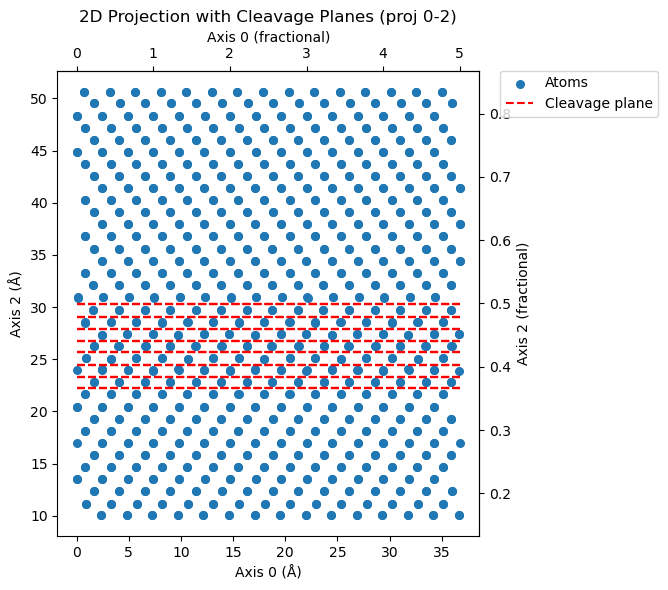

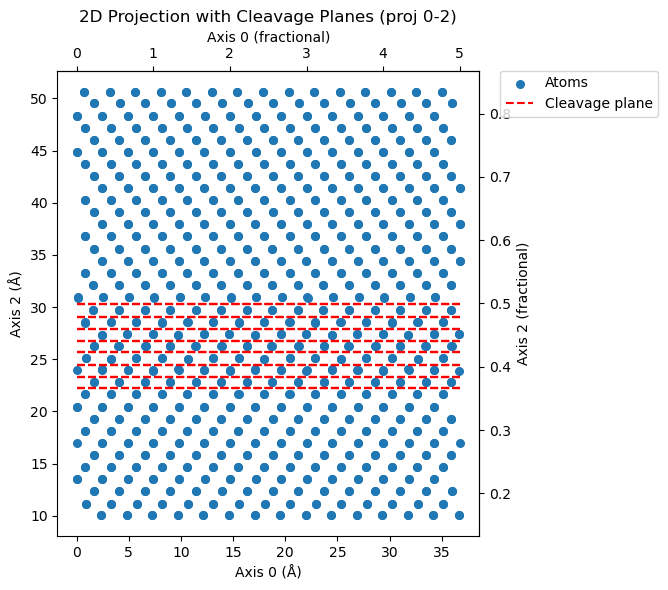

In [15]:
working_dir = "gb_cleavage_relax"

lmp_input = LammpsInput(
    read_data_file="lammps.data",
    pair_coeff=(
        "*", "*",
        "/root/github_dev/test_workflow_nodes/2025_04_29_FeGB_Segregation_Workflows/final_model",
        "Fe C"
    ),
    dump_every=10,
    dump_filename="dump.out",
    thermo_every=10,
    min_style="cg",
    maxeval=200,
    maxiter=200,
    etol=0.0001,
    ftol=0.01,
)
lammps_calculator_input = {
    "working_directory": "gb_cleavage",
    "lmp_input": lmp_input,
    "potential_elements": ["Fe", "C"],
    "input_filename": "in.lmp",
    "lammps_log_filepath": "minimize.log",
    "command": "/root/github_dev/lammps/build/lmp -in in.lmp -log minimize.log",
    "lammps_log_convergence_printout": "Total wall time:",
}

def get_non_element_idx(structure, element):
    return [i for i, e in enumerate(structure.get_chemical_symbols()) if e != element]

wf3 = pwf.Workflow(working_dir)
gb_seg_structure = wf2.gb_seg_calcs.outputs.output_df.value.atoms.iloc[0]
non_fe_idx = get_non_element_idx(gb_seg_structure, "Fe")

energy = wf2.gb_seg_calcs.outputs.output_df.value.results.iloc[0]["energy"]
from pyiron_workflow_atomistics.gb.cleavage import calc_cleavage_GB
wf3.calc_cleavage_rigid = calc_cleavage_GB(structure=gb_seg_structure,
                                           energy = energy,
                                        calc_structure_fn = lammps_calculator_node,
                                        calc_structure_fn_kwargs = lammps_calculator_input,
                                        parent_dir = working_dir,
                                        input_cleave_gb_structure = CleaveGBStructureInput(cleavage_target_coord=gb_seg_structure[non_fe_idx[0]].position[2]),
                                        input_plot_cleave = PlotCleaveInput(),
                                        rigid=True)
lmp_input = LammpsInput(
    read_data_file="lammps.data",
    pair_coeff=(
        "*", "*",
        "/root/github_dev/test_workflow_nodes/2025_04_29_FeGB_Segregation_Workflows/final_model",
        "Fe C"
    ),
    dump_every=10,
    dump_filename="dump.out",
    thermo_every=10,
    min_style="cg",
    maxeval=0,
    maxiter=0,
    etol=0.0001,
    ftol=0.01,
)
lammps_calculator_static_input = {
    "working_directory": "gb_cleavage_static",
    "lmp_input": lmp_input,
    "potential_elements": ["Fe", "C"],
    "input_filename": "in.lmp",
    "lammps_log_filepath": "minimize.log",
    "command": "/root/github_dev/lammps/build/lmp -in in.lmp -log minimize.log",
    "lammps_log_convergence_printout": "Total wall time:",
}
wf3.calc_cleavage_relaxed = calc_cleavage_GB(structure=gb_seg_structure,
                                           energy = energy,
                                        calc_structure_fn = lammps_calculator_node,
                                        calc_structure_fn_kwargs = lammps_calculator_static_input,
                                        parent_dir = "gb_cleavage_static",
                                        input_cleave_gb_structure = CleaveGBStructureInput(cleavage_target_coord=gb_seg_structure[non_fe_idx[0]].position[2]),
                                        input_plot_cleave = PlotCleaveInput(),
                                        rigid=True)
wf3.run()



In [16]:
wf3.save()